# Deep Learning

## Setup

In [21]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from datasets import Dataset, DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [22]:
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

generator = torch.Generator()
_ = generator.manual_seed(SEED)

In [23]:
all_label_strs = ['time_critical', 'support_and_relief', 'non_informative']
label2id = {label: i for i, label in enumerate(all_label_strs)}
id2label = {i: label for label, i in label2id.items()}

In [24]:
def load_data():
    df = {}
    for d in ['train', 'dev', 'test']:
        output_path = f"./data/crisisbench/preprocessed_data_{d}.csv"
        df[d] = pd.read_csv(output_path).loc[:, ['text', 'class_label_group', 'class_label_group_num']]
        print("Loading:", output_path)
    return df

df = load_data()

Loading: ./data/crisisbench/preprocessed_data_train.csv
Loading: ./data/crisisbench/preprocessed_data_dev.csv
Loading: ./data/crisisbench/preprocessed_data_test.csv


In [25]:
print(f"df_train: N={len(df['train'])}")
df['train'].head()

df_train: N=61089


,text,class_label_group,class_label_group_num
0,approximately km long firebreaks have been con...,time_critical,0
1,god bless you,non_informative,2
2,cracked wine casks damaged historical building...,time_critical,0
3,i m really just excited for new undies and pin...,non_informative,2
4,rescue effort e ands in india pakistan as floo...,time_critical,0


In [26]:
print(f"df_dev: N={len(df['dev'])}")
df['dev'].head()

df_dev: N=8921


,text,class_label_group,class_label_group_num
0,congrats to all my liverpool supporting fans f...,non_informative,2
1,collapsed buildings in mexico city earthquake ...,time_critical,0
2,here s your flower,non_informative,2
3,ready for a relaxing weekend but have too much...,non_informative,2
4,public private information portal developed to...,support_and_relief,1


In [27]:
print(f"df_test: N={len(df['test'])}")
df['test'].head()

df_test: N=17335


,text,class_label_group,class_label_group_num
0,staff at our feeding centre say chronic malnou...,support_and_relief,1
1,you comin down for the summer semesters right,non_informative,2
2,yea it s upstate i m like a few hours away,non_informative,2
3,teach every pakistani that it is not enough to...,non_informative,2
4,stay with for live cvg as typhoon hagupit slam...,time_critical,0


## CNN

### CNN Paper Setup
We train the CNN models using the Adam optimizer (Kingma and Ba 2014). The batch size is 128 and maximum number of epochs is set to 1000. We use a filter size of 300 with both window size and pooling length of 2, 3, and 4, and a dropout rate 0.02. We set early stopping
criterion based on the accuracy of the development set with a patience of 200. 

### Import Libraries

In [28]:

import math
from collections import Counter
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


### Hyperparameters

In [39]:

MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 64 # depends on tweet length
EMBED_DIM = 50
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 100
DROPOUT = 0.5 # tune
BATCH_SIZE = 64 # tune 
LR = 1e-3
NUM_EPOCHS = 20
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

GLOVE_PATH = "./data/crisisbench/glove_word_embeddings.txt"



### Tokenizer and Vocab

In [40]:
def simple_tokenize(text: str) -> List[str]:
    """
    Splits on whitespace
    """
    return text.strip().split()

def build_vocab(
    texts: List[str],
    max_size: int,
    min_freq: int = 1
) -> Dict[str, int]:
    """
    Build a word -> index vocab from training texts.
    Reserves index 0 for PAD and 1 for UNK.
    """
    counter = Counter()
    for text in texts:
        tokens = simple_tokenize(text)
        counter.update(tokens)

    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    for word, freq in counter.most_common():
        if freq < min_freq:
            continue
        if len(vocab) >= max_size:
            break
        vocab[word] = len(vocab)

    return vocab


def encode_text(
    text: str,
    vocab: Dict[str, int],
    max_len: int
) -> List[int]:
    tokens = simple_tokenize(text)
    ids = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens][:max_len]
    if len(ids) < max_len:
        ids += [vocab[PAD_TOKEN]] * (max_len - len(ids))
    return ids


### Dataset & DataLoader

In [41]:
class TextDataset(Dataset):
    def __init__(
        self,
        texts: List[str],
        labels: List[int],
        vocab: Dict[str, int],
        max_len: int,
    ):
        assert len(texts) == len(labels)
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = encode_text(text, self.vocab, self.max_len)
        return torch.tensor(input_ids, dtype=torch.long), label


def create_dataloaders(
    train_texts: List[str],
    train_labels: List[int],
    val_texts: List[str],
    val_labels: List[int],
    max_vocab_size: int,
    max_seq_len: int,
    batch_size: int,
) -> Tuple[DataLoader, DataLoader, Dict[str, int], int]:
    vocab = build_vocab(train_texts, max_vocab_size)
    num_classes = len(set(train_labels))

    train_dataset = TextDataset(train_texts, train_labels, vocab, max_seq_len)
    val_dataset = TextDataset(val_texts, val_labels, vocab, max_seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, vocab, num_classes


### Load GloVe & build embedding matrix

In [42]:
def load_glove_embeddings(
    glove_path: str,
    embed_dim: int,
) -> Dict[str, torch.Tensor]:
    """
    Load GloVe file into a dict: word -> vector (torch.Tensor).
    Expects each line: word val1 val2 ... valD
    """
    embeddings = {}
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != embed_dim + 1:
                # ignore malformed lines
                continue
            word = parts[0]
            vec = torch.tensor([float(x) for x in parts[1:]], dtype=torch.float32)
            embeddings[word] = vec
    return embeddings


def build_embedding_matrix(
    vocab: Dict[str, int],
    glove_embeddings: Dict[str, torch.Tensor],
    embed_dim: int,
) -> torch.Tensor:
    """
    Create an embedding matrix of shape [vocab_size, embed_dim]
    where row i is the vector for the word with index i.
    Words not found in GloVe are randomly initialized (small normal).
    """
    vocab_size = len(vocab)
    embedding_matrix = torch.empty(vocab_size, embed_dim, dtype=torch.float32)

    # Initialize OOV embeddings to small random values
    torch.nn.init.normal_(embedding_matrix, mean=0.0, std=0.05)

    # Set PAD embedding to zeros
    pad_idx = vocab[PAD_TOKEN]
    embedding_matrix[pad_idx] = torch.zeros(embed_dim, dtype=torch.float32)

    oov_count = 0
    for word, idx in vocab.items():
        if word in (PAD_TOKEN, UNK_TOKEN):
            continue
        vec = glove_embeddings.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
        else:
            oov_count += 1

    print(f"GloVe OOV words: {oov_count}/{vocab_size}")
    return embedding_matrix

### Text CNN model (with optional pretrained embeddings)

In [43]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        pad_idx: int = 0,
        num_filters: int = 100,
        filter_sizes: Tuple[int, ...] = (3, 4, 5),
        dropout: float = 0.5,
        pretrained_embeddings: torch.Tensor | None = None,
        freeze_embeddings: bool = False,
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx,
        )

        if pretrained_embeddings is not None:
            if pretrained_embeddings.shape != (vocab_size, embed_dim):
                raise ValueError(
                    f"Pretrained embeddings shape {pretrained_embeddings.shape} "
                    f"does not match (vocab_size, embed_dim)=({vocab_size}, {embed_dim})"
                )
            self.embedding.weight.data.copy_(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=num_filters,
                kernel_size=fs,
            )
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(input_ids)          # [B, L, D]
        embedded = embedded.transpose(1, 2)           # [B, D, L]

        conv_outputs = []
        for conv in self.convs:
            x = conv(embedded)                        # [B, F, L']
            x = F.relu(x)
            x = F.max_pool1d(x, x.size(2)).squeeze(2) # [B, F]
            conv_outputs.append(x)

        cat = torch.cat(conv_outputs, dim=1)          # [B, F * len(filter_sizes)]
        cat = self.dropout(cat)
        logits = self.fc(cat)                         # [B, num_classes]
        return logits

### Training & Evaluation

In [44]:
def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for input_ids, labels in dataloader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy


def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for input_ids, labels in dataloader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            logits = model(input_ids)
            loss = criterion(logits, labels)

            total_loss += loss.item() * input_ids.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy

### Main CNN Train Script

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create loaders and vocab
train_loader, val_loader, vocab, num_classes = create_dataloaders(
    train_texts=df['train']['text'].to_list(),
    train_labels=df['train']['class_label_group_num'],
    val_texts=df['dev']['text'].to_list(),
    val_labels=df['dev']['class_label_group_num'],
    max_vocab_size=MAX_VOCAB_SIZE,
    max_seq_len=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
)

print(f"Vocab size: {len(vocab)}, Num classes: {num_classes}")

# Load GloVe embeddings
print("Loading GloVe embeddings...")
glove_embeds = load_glove_embeddings(GLOVE_PATH, EMBED_DIM)
embedding_matrix = build_embedding_matrix(vocab, glove_embeds, EMBED_DIM)

# Initialize model with pretrained embeddings
print("Model Initialization...")
model = TextCNN(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    num_classes=num_classes,
    pad_idx=vocab[PAD_TOKEN],
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES,
    dropout=DROPOUT,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False,   # set True if you want to freeze GloVe
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Training...")
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_textcnn_glove.pt")

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

print(f"Best validation accuracy: {best_val_acc:.4f}")

Vocab size: 20000, Num classes: 3
Loading GloVe embeddings...
GloVe OOV words: 882/20000
Model Initialization...
Training...
Epoch 01 | Train Loss: 0.4643, Train Acc: 0.8228 | Val Loss: 0.3726, Val Acc: 0.8611
Epoch 02 | Train Loss: 0.3583, Train Acc: 0.8678 | Val Loss: 0.3546, Val Acc: 0.8683
Epoch 03 | Train Loss: 0.3105, Train Acc: 0.8871 | Val Loss: 0.3487, Val Acc: 0.8720
Epoch 04 | Train Loss: 0.2717, Train Acc: 0.9011 | Val Loss: 0.3596, Val Acc: 0.8681
Epoch 05 | Train Loss: 0.2371, Train Acc: 0.9152 | Val Loss: 0.3868, Val Acc: 0.8656
Epoch 06 | Train Loss: 0.2074, Train Acc: 0.9269 | Val Loss: 0.4027, Val Acc: 0.8644
Epoch 07 | Train Loss: 0.1804, Train Acc: 0.9359 | Val Loss: 0.4366, Val Acc: 0.8610
Epoch 08 | Train Loss: 0.1560, Train Acc: 0.9445 | Val Loss: 0.4877, Val Acc: 0.8584
Epoch 09 | Train Loss: 0.1368, Train Acc: 0.9521 | Val Loss: 0.5173, Val Acc: 0.8573
Epoch 10 | Train Loss: 0.1229, Train Acc: 0.9576 | Val Loss: 0.5811, Val Acc: 0.8566
Epoch 11 | Train Loss: 0.

### Calculate Metrics (Validation and Test)

In [46]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Helper to get predictions + labels from a DataLoader
def get_all_preds_and_labels(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, labels in dataloader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            logits = model(input_ids)          # [B, num_classes]
            preds = logits.argmax(dim=1)      # [B]

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_preds, all_labels

# compute accuracy, precision, recall, F1 (macro)
def compute_classification_metrics(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    average: str = "macro",   # "macro", "micro", or "weighted"
):
    preds, labels = get_all_preds_and_labels(model, dataloader, device)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average=average,
        zero_division=0,
    )

    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    return metrics

model.load_state_dict(torch.load("best_textcnn_glove.pt", map_location=device))

# For validation metrics
val_metrics = compute_classification_metrics(model, val_loader, device, average="macro")
print("Validation metrics:")
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")


# Test metrics
test_dataset = TextDataset(
    texts=df['test']['text'].to_list(),
    labels=df['test']['class_label_group_num'],
    vocab=vocab,
    max_len=MAX_SEQ_LEN,
)

from torch.utils.data import DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
model.load_state_dict(torch.load("best_textcnn_glove.pt", map_location=device))

# Simple loss + accuracy
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
test_metrics = compute_classification_metrics(model, test_loader, device, average="macro")
print("Test metrics:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

Validation metrics:
accuracy: 0.8720
precision: 0.8477
recall: 0.8071
f1: 0.8248
Test Loss: 0.3532, Test Acc: 0.8714
Test metrics:
accuracy: 0.8714
precision: 0.8391
recall: 0.8113
f1: 0.8239


### Plot Learning and Validation Curves

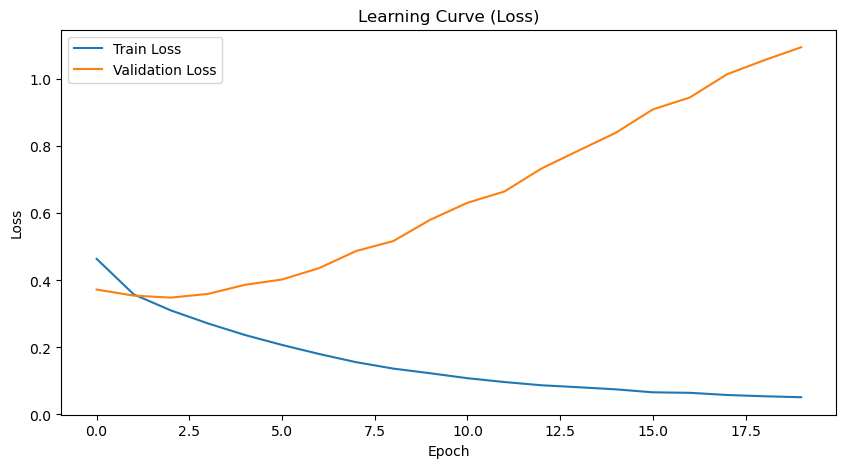

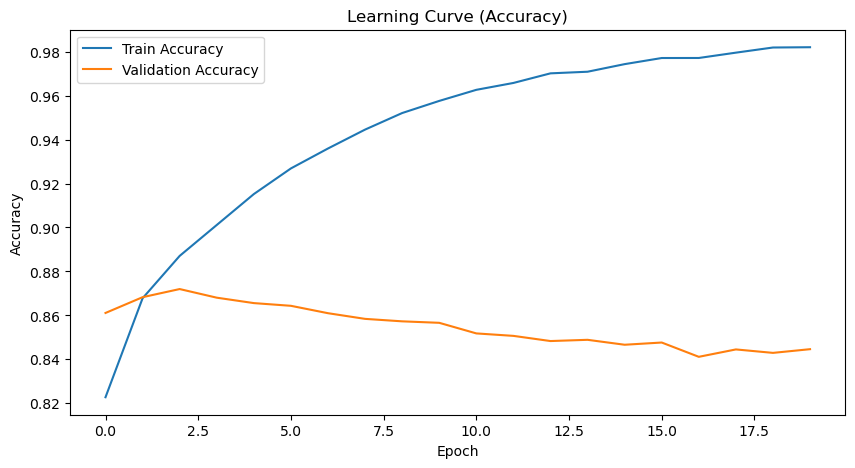

In [47]:
import matplotlib.pyplot as plt

# --- Loss plot ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss)")
plt.legend()
plt.savefig("cnn_loss_curve.png")

# --- Accuracy plot ---
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Accuracy)")
plt.legend()
plt.savefig("cnn_acc_curve.png")

Training TextCNN with num_filters=50
Training TextCNN with num_filters=100
Training TextCNN with num_filters=200
Training TextCNN with num_filters=300


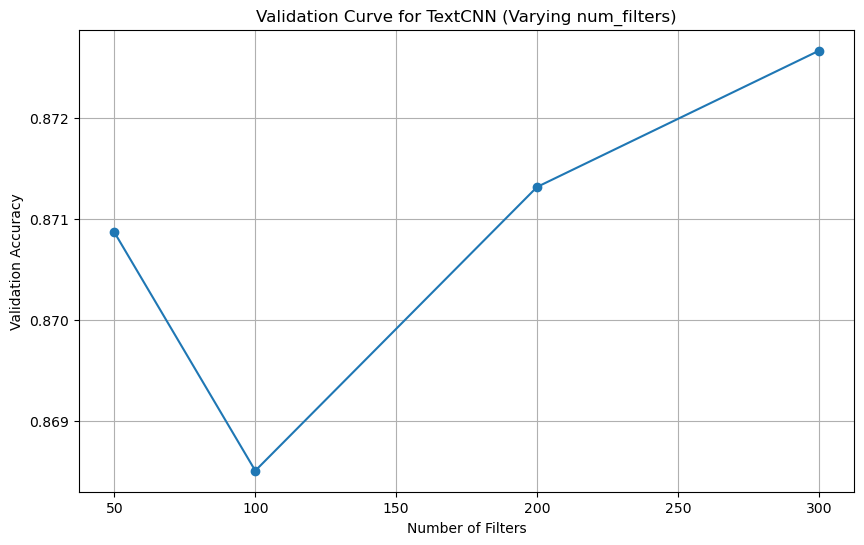

In [48]:
filter_sizes_to_test = [50, 100, 200, 300]

val_scores = []

for num_filters in filter_sizes_to_test:
    print(f"Training TextCNN with num_filters={num_filters}")

    model = TextCNN(
        vocab_size=len(vocab),
        embed_dim=EMBED_DIM,
        num_classes=num_classes,
        pad_idx=vocab[PAD_TOKEN],
        num_filters=num_filters,
        filter_sizes=FILTER_SIZES,
        dropout=DROPOUT,
        pretrained_embeddings=embedding_matrix,
        freeze_embeddings=False,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    # Train only a few epochs to keep experiments fast
    EPOCHS = 5
    best_val_acc = 0.0
    
    for _ in range(EPOCHS):
        train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    val_scores.append(best_val_acc)

plt.figure(figsize=(10, 6))
plt.plot(filter_sizes_to_test, val_scores, marker="o")
plt.xlabel("Number of Filters")
plt.ylabel("Validation Accuracy")
plt.title("Validation Curve for TextCNN (Varying num_filters)")
plt.grid(True)
plt.savefig("cnn_num_filters_validation_curve.png")
